# Gene prediction targets
Overexpressing essential genes in metabolic pathways is a commonly employed method to enhance the production of a desired molecule. As the increased production of naturally synthesized compounds typically involves genetic modification to metabolic pathways, a crucial initial step is to identify the critical pathways and specific genes to guide strategies for overexpressing or downregulating genes in subsequent manipulations [1].

**Cameo** provides algorithms to search for genes or reactions that can be over or down regulated in order to achieve a given biological objective: Flux Scanning based on Enforced Objective Flux (FSEOF) [2]. In this case our biological objective would be to optimize the flux towards the production of Ethylene. 

**FSEOF** scans all the metabolic fluxes in the metabolic model and selects fluxes that change when the flux toward product formation is enforced (gradually increased) as an additional constraint during flux analysis.

In [ ]:
pip install cobra

In [ ]:
pip install --upgrade cameo

In [3]:
from cobra.io import read_sbml_model
model = read_sbml_model('C:/Users/Ainara/Downloads/modified_model.xml')

In [4]:
from collections.abc import Mapping

In [8]:
from cameo import models
from cameo.strain_design.deterministic.flux_variability_based import FSEOF

In [9]:
fseof = FSEOF(model)
result = fseof.run(target=model.reactions.EFE_m)
df = result.data_frame
df

,1,2,3,4,5,6,7,8,9,10
ACALD,0.000000,0.000000,0.000000,0.000000,0.338702,2.098387,4.437898,5.226580,5.600629,5.974677
ACCOAL,0.000000,0.000000,0.000000,0.286491,0.308175,0.259659,0.209736,0.158903,0.107827,0.056751
ACONTa,4.988129,5.118482,5.252141,5.389344,6.382563,7.433429,8.481412,9.527532,10.573152,11.618773
ACONTb,4.988129,5.118482,5.252141,5.389344,6.382563,7.433429,8.481412,9.527532,10.573152,11.618773
ACS,0.527141,0.481976,0.436713,0.391343,0.342063,0.288212,0.232800,0.176377,0.119684,0.062992
...,...,...,...,...,...,...,...,...,...,...
TRPS1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022715,0.017209,0.011678,0.006146
VPAMTr,0.382896,0.350090,0.317212,0.284257,0.248462,0.209347,0.169097,0.128114,0.086934,0.045755
XYLI2,-0.000000,0.000000,0.163611,0.502661,0.365838,1.639877,3.805119,5.171160,6.323523,7.475887
RNTR1c2,0.023676,0.021648,0.019615,0.017577,0.015364,1.288331,3.491482,3.407482,2.711983,2.016485


The whole dataframe shows 90 rows, so we can conclude that there are 90 reactions that produce a change of flux.

After running the FSEOF analysis, we can plot the predicted targets that shows an increase or decrease in the flux when the target is set to the last step of the EFE_m reaction.

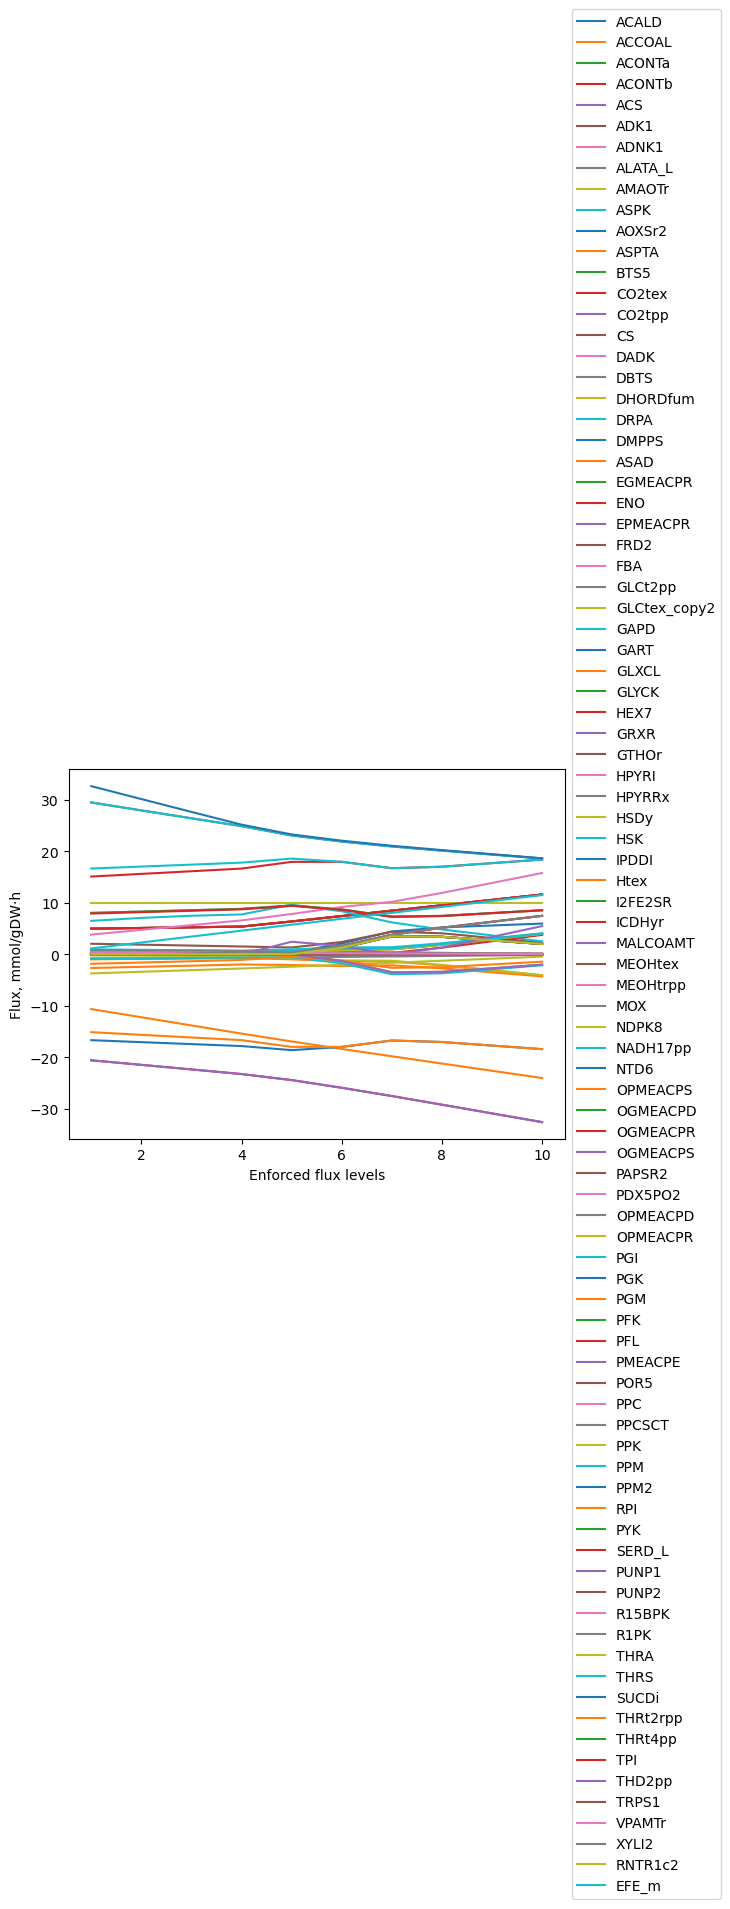

In [10]:
from matplotlib import pyplot as plt
result.data_frame.T.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Enforced flux levels")
plt.ylabel("Flux, mmol/gDW·h")
plt.show()

Then, we can plot all of the data in a more representative way, where the reactions with a positive change in the flux are represented in green and the ones with a negative change in the flux are shown in red:

C:\Users\Ainara\AppData\Local\Temp\ipykernel_16812\1140286807.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.index, rotation=90, ha='center')


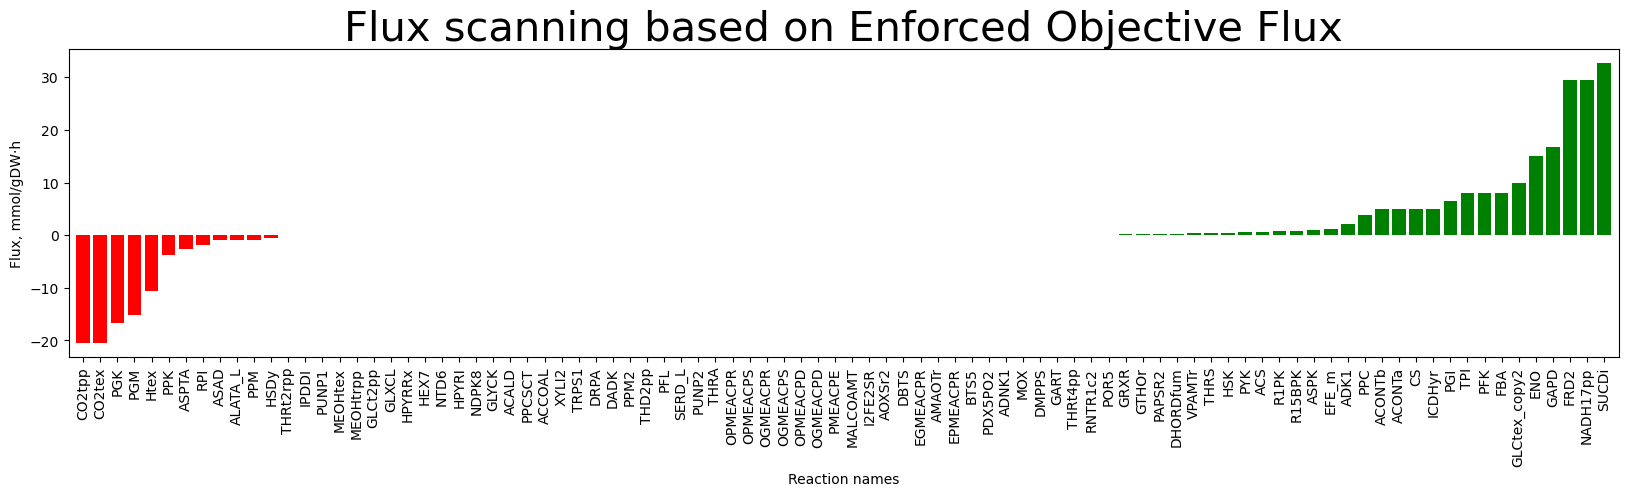

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = df.sort_values(by=df.columns[0], ascending=True)

def bar_color(df, color1, color2):
    return np.where(df.values >= 0, color1, color2)

fig, ax = plt.subplots(figsize=(20, 4))
bars = ax.bar(df.index, df[df.columns[0]], color=bar_color(df[df.columns[0]], 'green', 'red'))

ax.set_ylabel('Flux, mmol/gDW·h')
ax.set_xlabel('Reaction names')
ax.set_title('Flux scanning based on Enforced Objective Flux', size=30)

ax.set_xticklabels(df.index, rotation=90, ha='center')
ax.margins(x=0.005)


plt.show()


Next, we can delete all the targets that have a flux change of 0.0, so we can obtain the reactions that show the highest increase or decrease in flux:

In [12]:
from pytest import approx
# removing genes from dataframe 
removed_zero = (df != approx(0.0)).all(axis=1)
df = df.loc[removed_zero]

### Downregulation

The reaction's fluxes that decrease when we enforced the ethylene reaction are the ones that could potentially be downregulated in order to improve the ethylene production.

For obtaining these reactions, we filter the data to obtain the ones that produce a decrease in our target flux greater than 95% and statically significative: 

In [13]:
down = []
for row in range(len(df[1])):
    if df[1][row]==0.0:
         continue   
    elif df[10][row]<df[1][row] and abs(df[1][row]-df[10][row])/abs(df[1][row])>1.95:
        down.append(df.index[row])
Reactions_down=df.T[down].T.sort_values(by=[10])
Reactions_down

,1,2,3,4,5,6,7,8,9,10
ASAD,-0.967349,-0.884467,-0.801404,-0.718147,-0.966416,-1.351894,-1.384079,-2.150687,-3.113652,-4.076617
HSDy,-0.631697,-0.577574,-0.523332,-0.468964,-0.748612,-1.168378,-1.235846,-2.038381,-3.037444,-4.036508
PUNP1,-0.000609,-0.000557,-0.000504,-0.000452,-0.000395,-1.275719,-3.481295,-3.399764,-2.706746,-2.013728


And this data was represented in a plot:

Text(0.5, 1.0, 'Reactions that affects negatively to ethylene production with a relative change in Flux > 95%')

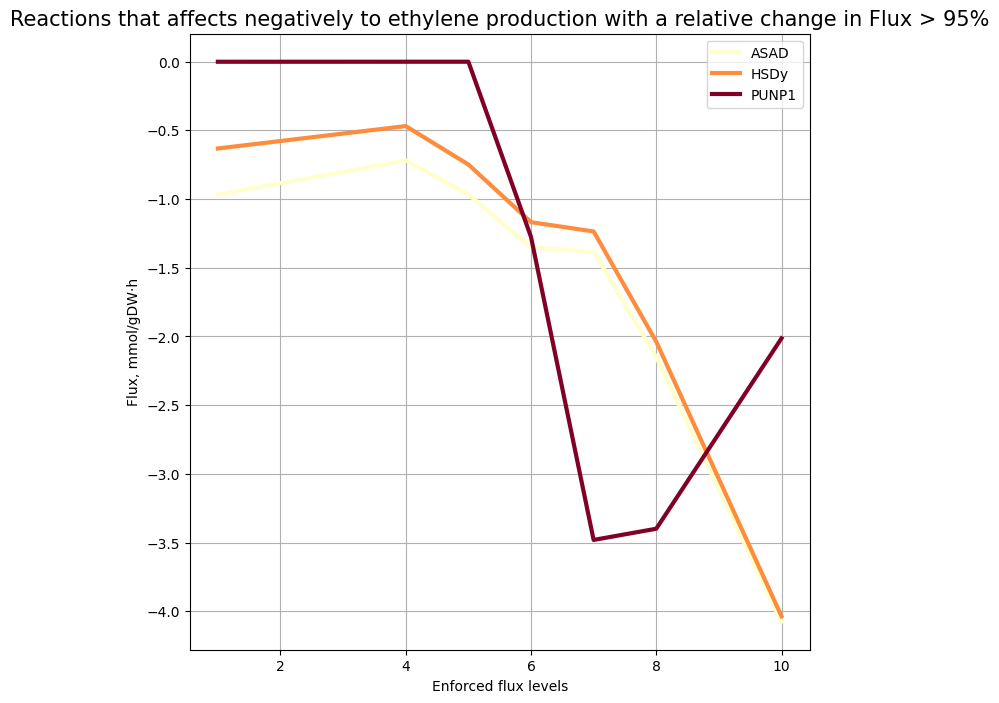

In [12]:
fig = Reactions_down.T.plot(cmap="YlOrRd",figsize=(8, 8), grid =True, linewidth=3);
fig.set_ylabel('Flux, mmol/gDW·h')
fig.set_xlabel('Enforced flux levels')
fig.set_title('Reactions that affects negatively to ethylene production with a relative change in Flux > 95%', size=15)

We can identify all these reactions by doing a search within our model:

In [13]:
from cobra.io import read_sbml_model
from cobra import Reaction, Metabolite
model = read_sbml_model('/workspaces/group-assingment-group-2/models/modified_model.xml')

In [14]:
reactions_to_check=list(Reactions_down.index)

for reaction in model.reactions:
    if reaction.id in reactions_to_check:
        print (reaction.name, reaction)

Aspartate-semialdehyde dehydrogenase ASAD: aspsa_c + nadp_c + pi_c <=> 4pasp_c + h_c + nadph_c
Homoserine dehydrogenase (NADPH) HSDy: hom__L_c + nadp_c <=> aspsa_c + h_c + nadph_c
Purine-nucleoside phosphorylase (Adenosine) PUNP1: adn_c + pi_c <=> ade_c + r1p_c


#### Reduction of lower and upper boundry for the genes to downregulate

In order to study the effect of the yield of production of ethylene, we decreased the lower and upper boundry of the 3 reactions that gave us a change in the flux of >95%.
For that, firstly we calculate the yield of the reaction without any change:

In [15]:
with model:
    solution = model.optimize()
    print('Maximum theoretical biomass productivity:', solution.fluxes['BIOMASS_Ec_iJO1366_core_53p95M'], '/h')

    model.objective = model.reactions.EFE_m
    E_production = model.optimize().objective_value
    print('Maximum theoretical productivity of Ethylene_forming_enzyme_main reaction:', E_production, 'mmol/gDW*h')

Maximum theoretical biomass productivity: 0.982371812714834 /h
Maximum theoretical productivity of Ethylene_forming_enzyme_main reaction: 12.780573951434915 mmol/gDW*h


Then, we will study the change of this yield for each reaction:

**Aspartate-semialdehyde dehydrogenase (ASAD)**

The Aspartate-semialdehyde dehydrogenase (ASAD) catalyses the reductive dephosphorylation of aspartate semialdehyde to aspartyl phosphate. The downregulation of the ASAD enzyme will lead into the increase of aspartate semialdehyde, and hence of aspartate. The increase of aspartate would produce an increase in oxaloacetate (aspartate aminotransferase), producing an overproduction of 2-oxoglutarate, the substrate of our EFE reaction for producing ethylene.

As ASAD reaction is a reversible one, we will try to downregulate the flux of the part of the reaction that catalyze the production of aspartyl phosphate. For that, we decrease the upper boundry:

In [32]:
model.reactions.ASAD.bounds =-1000, 0.00001

In [33]:
with model:
    solution = model.optimize()
    print('Maximum theoretical biomass productivity:', solution.fluxes['BIOMASS_Ec_iJO1366_core_53p95M'], '/h')

    model.objective = model.reactions.EFE_m
    E_production = model.optimize().objective_value
    print('Maximum theoretical productivity of Ethylene_forming_enzyme_main reaction:', E_production, 'mmol/gDW*h')

Maximum theoretical biomass productivity: 0.9823718127269826 /h
Maximum theoretical productivity of Ethylene_forming_enzyme_main reaction: 12.780573951434897 mmol/gDW*h


In [34]:
model.reactions.ASAD.bounds

(-1000, 1e-05)

In [35]:
model.reactions.ASAD.bounds=-1000,1000 #to reset the values

Nevertheless, although we expected to see some improve in the ethylene yield, we couldn't see any increase in its productivity.

**Homoserine dehydrogenase (HSDy)**

Homoserine dehydrogenase (HSDy) catalyzes the reaction from aspartate-dehydrogenase to homoserine. Again, the downregulation of HSDy will lead to an increase in aspartate and therefore, in 2-oxoglutarate.

As HSDy reaction is also reversible, we try to downregulate the lower boundry, so we can redirect the reaction to the production of aspartate.

In [62]:
model.reactions.HSDy.bounds = -1, 1000

In [63]:
with model:
    solution = model.optimize()
    print('Maximum theoretical biomass productivity:', solution.fluxes['BIOMASS_Ec_iJO1366_core_53p95M'], '/h')

    model.objective = model.reactions.EFE_m
    E_production = model.optimize().objective_value
    print('Maximum theoretical productivity of Ethylene_forming_enzyme_main reaction:', E_production, 'mmol/gDW*h')

Maximum theoretical biomass productivity: 0.9823718127269887 /h
Maximum theoretical productivity of Ethylene_forming_enzyme_main reaction: 12.573239436619632 mmol/gDW*h


In [64]:
model.reactions.HSDy.bounds

(-1, 1000)

In [65]:
model.reactions.HSDy.bounds = -1000, 1000 #to reset the values

However, again we could not see an increase in the ethylene yield.

### Overexpression

For obtaining which genes could be overexpressed in order to increase the flux towards the production of ethylene, we filter again the data to obtain the genes that produce an increase in our target flux greater than 95%: 

In [69]:
up = []
for row in range(len(df[1])):
        if df[1][row]==0.0:
            continue
        elif df[10][row]>df[1][row] and abs(df[10][row]-df[1][row])/abs(df[10][row])>1.95:
            up.append(df.index[row])
Reactions_up=df.T[up].T.sort_values(by=[10])
Reactions_up

C:\Users\Ainara\AppData\Local\Temp\ipykernel_16812\2431829036.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  elif df[10][row]>df[1][row] and abs(df[10][row]-df[1][row])/abs(df[10][row])>1.95:


,1,2,3,4,5,6,7,8,9,10
PPK,-3.697347,-3.380562,-3.063084,-2.744863,-2.399215,-2.021507,-1.632846,-1.237101,-0.839461,-0.441822
ALATA_L,-0.908934,-0.831057,-0.753010,-0.674781,-0.589808,-0.496955,-0.401409,-0.304121,-0.206368,-0.108615
THRt2rpp,-0.004710,-0.004306,-0.003902,-0.003496,-0.003056,-0.002575,-0.002080,-0.001576,-0.001069,-0.000563
IPDDI,-0.001910,-0.001746,-0.001582,-0.001418,-0.001239,-0.001044,-0.000844,-0.000639,-0.000434,-0.000228
MEOHtex,-0.000002,-0.000002,-0.000001,-0.000001,-0.000001,-0.000001,-0.000001,-0.000001,-0.000000,-0.000000
MEOHtrpp,-0.000002,-0.000002,-0.000001,-0.000001,-0.000001,-0.000001,-0.000001,-0.000001,-0.000000,-0.000000


Text(0.5, 1.0, 'Reactions that affects positively to ethylene production with a relative change in Flux > 95%')

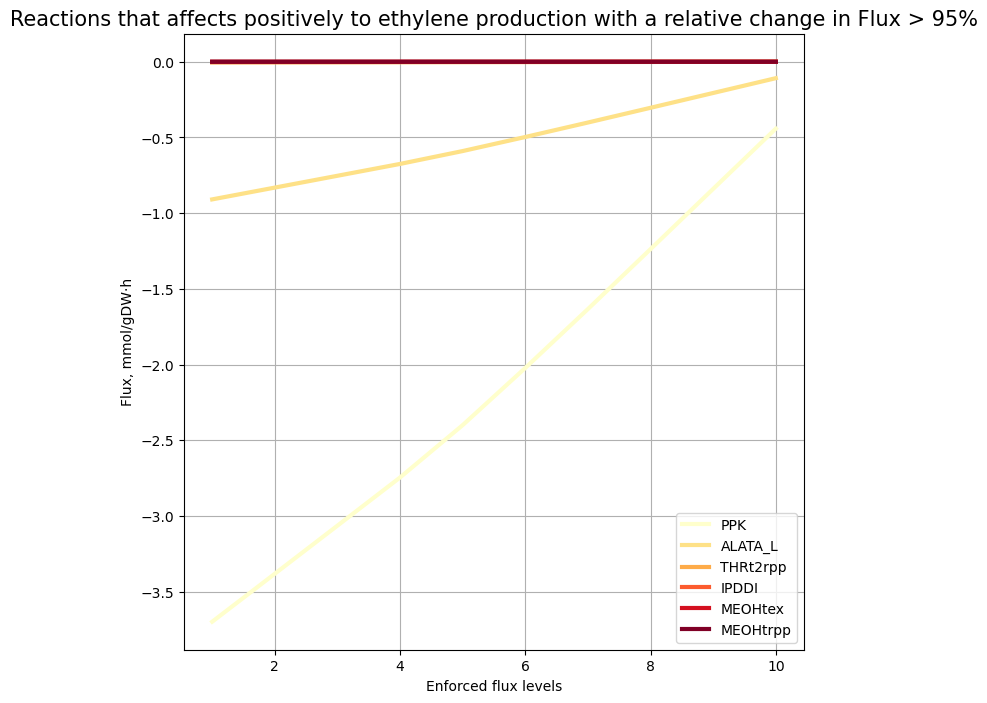

In [70]:
fig = Reactions_up.T.plot(cmap="YlOrRd",figsize=(8, 8), grid =True, linewidth=3);
fig.set_ylabel('Flux, mmol/gDW·h')
fig.set_xlabel('Enforced flux levels')
fig.set_title('Reactions that affects positively to ethylene production with a relative change in Flux > 95%', size=15)

We identify all these reactions by doing a search within our model:

In [71]:
reactions_to_check=list(Reactions_up.index)

for reaction in model.reactions:
    if reaction.id in reactions_to_check:
        print (reaction.name, reaction)

L-alanine transaminase ALATA_L: akg_c + ala__L_c <=> glu__L_c + pyr_c
Isopentenyl-diphosphate D-isomerase IPDDI: ipdp_c <=> dmpp_c
Methanol transport via diffusion (extracellular to periplasm) MEOHtex: meoh_e <=> meoh_p
Methanol reversible transport via diffusion (periplasm) MEOHtrpp: meoh_p <=> meoh_c
Polyphosphate kinase PPK: atp_c + pi_c <=> adp_c + ppi_c
L-threonine reversible transport via proton symport (periplasm) THRt2rpp: h_p + thr__L_p <=> h_c + thr__L_c


For the case of the L-alanine transaminase (ALATA_L), it catalyzes the transfer of an amino group from alanine to 2-oxoglutarate (or alpha-ketoglutarate). Thus, overexpressing this enzyme could lead into an increase in the substrate of our target reaction.

#### References
[1] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5699525/

[2] https://cameo.readthedocs.io/en/latest/06-predict-gene-modulation-targets.html?highlight=fseof

[3] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2869140/ 